In [1]:
# -*- coding: utf8 -*-


from sirsaia import brasilio
from sirsaia import epiestim
from sirsaia import plotutils


import glob
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/robjects/pandas2ri.py:14: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index as PandasIndex


In [2]:
plt.ion()
plt.style.use('seaborn-colorblind')
plt.rcParams['figure.figsize']  = (12, 8)

In [4]:
config = epiestim.make_config(mean_si=5, std_si=2, si_parametric_distr='weibull')

/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


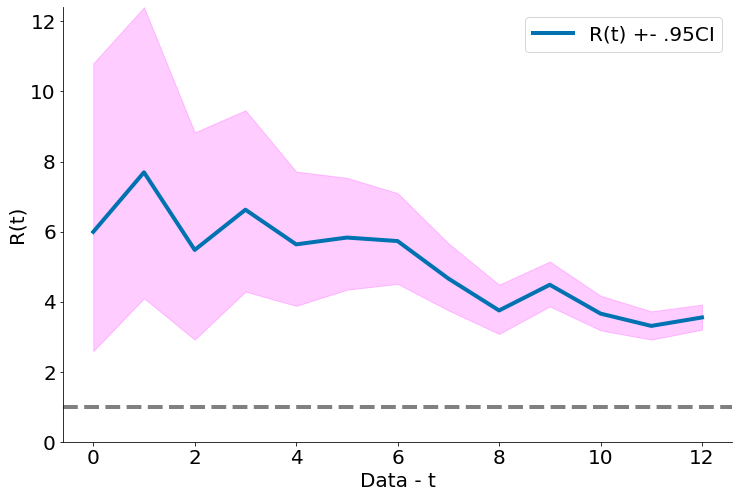

In [9]:
df_orig = pd.read_excel('./data/COVID-19-geographic-disbtribution-worldwide-2020-03-28.xlsx')
df_br = df_orig[df_orig['countriesAndTerritories'] == 'Brazil']
who_df = df_br[['cases']].copy()
who_df.columns = ['local']
who_df.index = pd.to_datetime(df_br['dateRep'])
who_df = who_df.sort_index().fillna(0)
first_day = np.nonzero(who_df.values)[0][0]
who_df = who_df[first_day:]
who_df = who_df[:'2020-03-19']

epiestim_result = epiestim.estimate_r(who_df, config)
plotutils.plot_result(epiestim_result)

In [6]:
datasets = {}
sheets = glob.glob('data/covid19/[A-Z]*/*.xlsx')
for sheet in sorted(sheets):
    state = os.path.basename(sheet)[:2]
    region = os.path.basename(os.path.dirname(sheet))
    if region not in datasets:
        datasets[region] = {}
    datasets[region][state] = sheet

In [27]:
for region in datasets:
    for state, fpath in datasets[region].items():
        df = brasilio.load_data(fpath)
        model_df = df[['TOTAL NO ESTADO', 'Importados/Indefinidos']].copy()
        model_df.columns = ['local', 'imported']
        epiestim_result = epiestim.estimate_r(model_df)
        plotutils.plot_result(epiestim_result, model_df)
        plt.title(state + ' last mean = {}'.format(epiestim_result['Mean(R)'].values[-1]))
        try:
            os.makedirs('plots/{}/'.format(region))
        except:
            pass
        plt.tight_layout()
        plt.savefig('plots/{}/{}.png'.format(region, state))
        plt.close()

Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To ch

Ignoring imported column, all zeros


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)
/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


/home/flaviovdf/miniconda3/envs/corona/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:145: RRuntimeWarning: Default config will estimate R on weekly sliding windows.
    To change this change the t_start and t_end arguments. 

  warnings.warn(x, RRuntimeWarning)


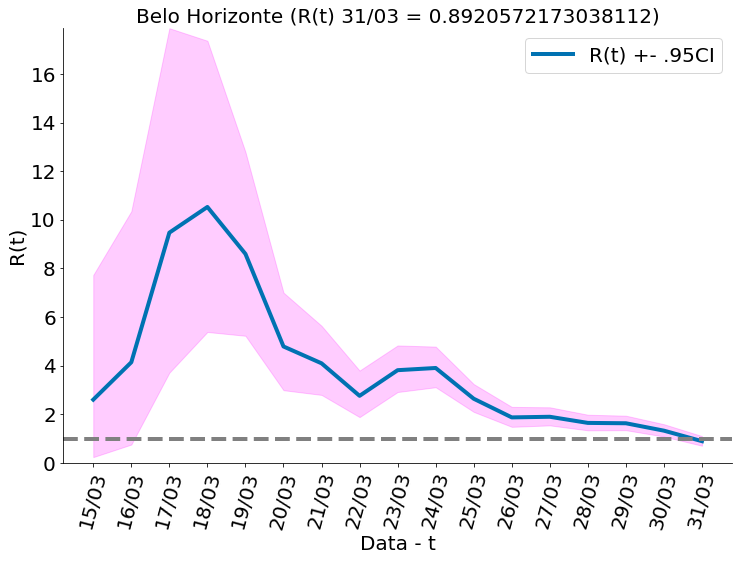

In [26]:
df = brasilio.load_data('data/covid19/Sudeste/MG.xlsx')
model_df = df[['Belo Horizonte']].copy()
model_df.columns = ['local']
epiestim_result = epiestim.estimate_r(model_df)
plt.title('Belo Horizonte (R(t) 31/03 = {})'.format(epiestim_result['Mean(R)'].values[-1]))
plotutils.plot_result(epiestim_result, model_df)

In [12]:
epiestim_result

,t_start,t_end,Mean(R),Std(R),Quantile.0.025(R),Quantile.0.05(R),Quantile.0.25(R),Median(R),Quantile.0.75(R),Quantile.0.95(R),Quantile.0.975(R)
1,2.0,8.0,4.152056,0.928428,2.536184,2.751703,5.787808,4.083064,5.787808,5.787808,6.159752
2,3.0,9.0,6.135504,0.995310,4.341848,4.595155,7.859175,6.081769,7.859175,7.859175,8.234432
3,4.0,10.0,6.275877,0.862058,4.701062,4.928355,7.757899,6.236450,7.757899,7.757899,8.074695
4,5.0,11.0,5.041265,0.635140,3.873846,4.043982,6.129454,5.014617,6.129454,6.129454,6.360092
5,6.0,12.0,4.137615,0.462599,3.280871,3.407224,4.926773,4.120388,4.926773,4.926773,5.092244
6,7.0,13.0,3.591634,0.353894,2.931608,3.030018,4.192879,3.580018,4.192879,4.192879,4.317669
7,8.0,14.0,2.739104,0.262359,2.249090,2.322314,3.184453,2.730732,3.184453,3.184453,3.276690
8,9.0,15.0,2.443035,0.215097,2.039666,2.100321,2.807273,2.436725,2.807273,2.807273,2.882259
9,10.0,16.0,1.832277,0.164543,1.523993,1.570285,2.111064,1.827354,2.111064,2.111064,2.168536
10,11.0,17.0,1.529363,0.135178,1.275911,1.314013,1.758294,1.525383,1.758294,1.758294,1.805436
